# Quantium - Task 1: Data preparation and customer analytics

## Dependencies

Required packages to run this notebook. 

In [1]:
!pip install pandas xlrd matplotlib wordcloud scipy

## Loading datasets

In [2]:
import pandas as pd

pd.options.mode.chained_assignment = None

In [3]:
df_transaction_data = pd.read_excel('data/QVI_transaction_data.xlsx',
                                   parse_dates=True)
df_transaction_data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,43533,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,43325,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,43410,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,43461,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


Check the encoding of the csv file first.

In [4]:
import chardet

with open('data/QVI_purchase_behaviour.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# Check what the character encoding might be
result

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [5]:
df_purchase_behaviour = pd.read_csv('data/QVI_purchase_behaviour.csv', encoding='ascii')
df_purchase_behaviour

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
...,...,...,...
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget


## Data exploration and cleaning

We'll be doing it one at a time, starting with "Transaction Data"

Get information for the current dataset

In [6]:
df_transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


It doesn't look lik we have missing data but, just to be sure:

In [7]:
df_transaction_data[df_transaction_data.isnull().any(axis=1)]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES


Are there any duplicated transaction? this might not tell us the whole story, maybe a salesman uploaded the same transaction more than once or maybe the same customer returned the same date to make exactly the same purchase.

In [8]:
df_transaction_data[df_transaction_data.duplicated(keep=False)]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
124843,43374,107,107024,108462,45,Smiths Thinly Cut Roast Chicken 175g,2,6.0
124845,43374,107,107024,108462,45,Smiths Thinly Cut Roast Chicken 175g,2,6.0


As it has the same TXN_ID let's assume it's an error and remove it.

In [9]:
df_transaction_data = df_transaction_data[~df_transaction_data.duplicated()]

Now Let's look at the DATE values

In [10]:
df_transaction_data['DATE']

0         43390
1         43599
2         43605
3         43329
4         43330
          ...  
264831    43533
264832    43325
264833    43410
264834    43461
264835    43365
Name: DATE, Length: 264835, dtype: int64

Date seems to be in integer format, we should change that.

In [11]:
from datetime import timedelta

# It's better to not replace original columns in case we might have missed something and we accidentally remove usefull data
df_transaction_data['OLD_DATE'] = df_transaction_data['DATE']

In [12]:
df_transaction_data['DATE'] = pd.to_datetime(df_transaction_data['DATE'], unit='D', origin="1899-12-30")
df_transaction_data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,OLD_DATE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,43390
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,43599
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,43605
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,43329
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,43330
...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,43533
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,43325
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,43410
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,43461


Let's have a sample of 'PROD_NAME' in the data 

In [13]:
df_transaction_data['PROD_NAME'].sample(15)

187242           RRD Honey Soy       Chicken 165g
45696          Kettle Sensations   BBQ&Maple 150g
205717            Doritos Salsa       Medium 300g
178528      Kettle Sensations   Siracha Lime 150g
165085      Kettle Sensations   Siracha Lime 150g
49954      Kettle Mozzarella   Basil & Pesto 175g
149869      Red Rock Deli Chikn&Garlic Aioli 150g
46670             Twisties Cheese     Burger 250g
149016          Smiths Crinkle      Original 330g
34406            Doritos Cheese      Supreme 330g
148659             Pringles SourCream  Onion 134g
258741         Kettle Sensations   BBQ&Maple 150g
18834                        Kettle Original 175g
81823     Doritos Corn Chips  Cheese Supreme 170g
182230            Pringles Original   Crisps 134g
Name: PROD_NAME, dtype: object

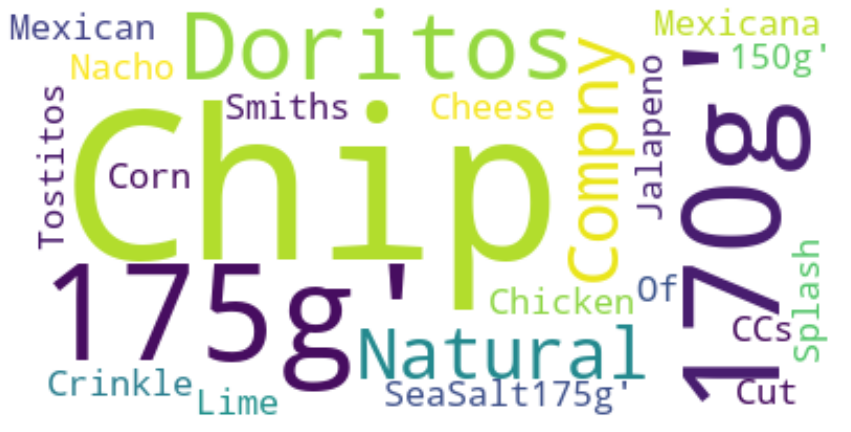

In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


wordcloud = WordCloud(
    max_font_size=100, 
    max_words=500, 
    stopwords=STOPWORDS,
    background_color = 'white').generate(str(df_transaction_data.PROD_NAME.values))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

Our focus in this task was supposed, but we can find some 'salsas' in the data, and also we find some special characters. We'll clean those.

In [15]:
# It's better to not replace original columns in case we might have missed something and we accidentally remove usefull data
df_transaction_data['OLD_PROD_NAME'] = df_transaction_data['PROD_NAME']

In [16]:
import re 

df_transaction_data = df_transaction_data[~df_transaction_data.PROD_NAME.str.contains('Salsa')].reset_index()
df_transaction_data.PROD_NAME = df_transaction_data.PROD_NAME.apply(lambda x: ''.join([s for s in x if s.isalnum() or (s == ' ')]))
df_transaction_data

,index,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,OLD_DATE,OLD_PROD_NAME
0,0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,43390,Natural Chip Compny SeaSalt175g
1,1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,43599,CCs Nacho Cheese 175g
2,2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,43605,Smiths Crinkle Cut Chips Chicken 170g
3,3,2018-08-17,2,2373,974,69,Smiths Chip Thinly SCreamOnion 175g,5,15.0,43329,Smiths Chip Thinly S/Cream&Onion 175g
4,4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHnyJlpno Chili 150g,3,13.8,43330,Kettle Tortilla ChpsHny&Jlpno Chili 150g
...,...,...,...,...,...,...,...,...,...,...,...
246736,264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,43533,Kettle Sweet Chilli And Sour Cream 175g
246737,264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,43325,Tostitos Splash Of Lime 175g
246738,264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,43410,Doritos Mexicana 170g
246739,264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,43461,Doritos Corn Chip Mexican Jalapeno 150g


We might notice that there is more information within 'PROD_NAME' than just the name. Let's check it.

In [17]:
df_transaction_data.PROD_NAME.sample(1)

142091    Cobs Popd Sea Salt  Chips 110g
Name: PROD_NAME, dtype: object

It seems that the field 'PROD_NAME' follows the next convention: Brand Product Weight, we'll split the column into 3 to better analize the available data.

In [18]:
import re

brand_name = df_transaction_data['OLD_PROD_NAME'].str.split(" ", n = 1, expand = True)[0] 
pack_size = df_transaction_data['OLD_PROD_NAME'].apply(lambda x: int(re.findall(r'\d+',x)[0]))
prod_name = df_transaction_data['OLD_PROD_NAME'].apply(lambda x: re.search(r' .*?(?=[0-9])',x).group(0))

df_transaction_data['BRND_NAME'] = brand_name
df_transaction_data['PCK_SIZE'] = pack_size
df_transaction_data['PROD_NAME'] = prod_name

df_transaction_data = df_transaction_data[['OLD_DATE', 'DATE', 'STORE_NBR', 'LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NBR', 'OLD_PROD_NAME','PROD_NAME', 'BRND_NAME', 'PCK_SIZE', 'PROD_QTY', 'TOT_SALES']].reset_index()
df_transaction_data

,index,OLD_DATE,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,OLD_PROD_NAME,PROD_NAME,BRND_NAME,PCK_SIZE,PROD_QTY,TOT_SALES
0,0,43390,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,Chip Compny SeaSalt,Natural,175,2,6.0
1,1,43599,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,Nacho Cheese,CCs,175,3,6.3
2,2,43605,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,Crinkle Cut Chips Chicken,Smiths,170,2,2.9
3,3,43329,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,Chip Thinly S/Cream&Onion,Smiths,175,5,15.0
4,4,43330,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,Tortilla ChpsHny&Jlpno Chili,Kettle,150,3,13.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246736,246736,43533,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,Sweet Chilli And Sour Cream,Kettle,175,2,10.8
246737,246737,43325,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,Splash Of Lime,Tostitos,175,1,4.4
246738,246738,43410,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,Mexicana,Doritos,170,2,8.8
246739,246739,43461,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,Corn Chip Mexican Jalapeno,Doritos,150,2,7.8


What packets size are there? What packet size people prefer?

<AxesSubplot:ylabel='Frequency'>

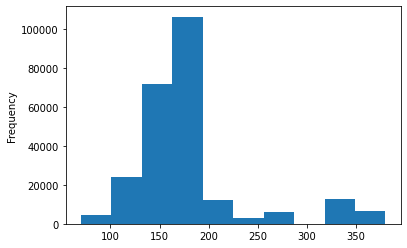

In [19]:
df_transaction_data.PCK_SIZE.plot.hist()

Let's take a look at the unique brands in our dataset

In [20]:
df_transaction_data.BRND_NAME.unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

Some brands seem to reference the same brand but with different identifier, such as Red and RRD, and Snbts and Sunbites.

In [21]:
df_transaction_data.BRND_NAME = df_transaction_data.BRND_NAME.apply(lambda x: 'RRD' if x == 'Red' else x)

In [22]:
df_transaction_data.BRND_NAME = df_transaction_data.BRND_NAME.apply(lambda x: 'Sunbites' if x == 'Snbts' else x)
df_transaction_data.BRND_NAME.unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'RRD', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'Tostitos', 'Cheetos', 'Woolworths',
       'Sunbites'], dtype=object)

Describe 'PROD_NAME' and 'BRND_NAME' columns, this show us how many unique products/brands are, the most popular and the frecuency that value repeated.

In [23]:
df_transaction_data[['PROD_NAME', 'BRND_NAME']].describe()

,PROD_NAME,BRND_NAME
count,246741,246741
unique,104,26
top,Original,Kettle
freq,4673,41288


If we are interested, we can see a ranking for brands and products for more details

In [24]:
# Top 5 and Worst 5
df_transaction_data[['PROD_NAME','PROD_NBR']].groupby('PROD_NAME').count().sort_values(by='PROD_NBR',ascending=False)

,PROD_NBR
PROD_NAME,
Original,4673
Mozzarella Basil & Pesto,3304
Tortilla ChpsHny&Jlpno Chili,3296
Popd Swt/Chlli &Sr/Cream Chips,3269
Crisps Ched & Chives,3268
...,...
Whlegrn Crisps Frch/Onin,1432
Pc Sea Salt,1431
Sour Cream & Garden Chives,1419


In [25]:
# Top 10 brands
df_transaction_data[['BRND_NAME','PROD_NBR']].groupby('BRND_NAME').count().sort_values(by='PROD_NBR',ascending=False).head(10)

,PROD_NBR
BRND_NAME,
Kettle,41288
Smiths,27389
Pringles,25102
Doritos,22041
RRD,16321
Thins,14075
Infuzions,11057
WW,10320
Cobs,9693


In [26]:
# Top 10 products or flavours
df_transaction_data[['PROD_NBR','PROD_NAME']].sample(10)

,PROD_NBR,PROD_NAME
62495,54,Original
212015,113,Chicken
238537,16,Crinkle Chips Salt & Vinegar
190789,93,Corn Chip Southern Chicken
52520,105,Cheese Rings
99963,91,Tasty Cheese
129664,55,Whlgrn Crisps Cheddr&Mstrd
90678,78,Chips Salt & Vinegar
45084,93,Corn Chip Southern Chicken
39438,62,Mystery Flavour


Describe numeric columns 'PROD_QTY', 'TOT_SALES' and 'PCK_SIZE'. This function returns some statitical values to better understand customer behaviour  like median quantity of products per transaction, maximun value of sale and median value of sale per transaction.

In [27]:
df_transaction_data[['PROD_QTY','TOT_SALES','PCK_SIZE']].describe()

,PROD_QTY,TOT_SALES,PCK_SIZE
count,246741.000000,246741.000000,246741.000000
mean,1.908061,7.321328,175.585180
std,0.659832,3.077833,59.434847
min,1.000000,1.700000,70.000000
25%,2.000000,5.800000,150.000000
50%,2.000000,7.400000,170.000000
75%,2.000000,8.800000,175.000000
max,200.000000,650.000000,380.000000


Something seems odd, a transaction with PROD_QTY of 200 when the mean is 1.9 with std of 0.65? let's check how often happens. 

In [28]:
df_transaction_data[df_transaction_data.PROD_QTY >= 100]

,index,OLD_DATE,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,OLD_PROD_NAME,PROD_NAME,BRND_NAME,PCK_SIZE,PROD_QTY,TOT_SALES
64955,64955,43331,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,Corn Chp Supreme,Dorito,380,200,650.0
64956,64956,43605,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,Corn Chp Supreme,Dorito,380,200,650.0


There are 2 transactions of 200 PROD_QTY and from the same customer (same LYLTY_CARD_NBR), has this customer bought something else?

In [29]:
df_transaction_data[df_transaction_data.LYLTY_CARD_NBR == 226000]

,index,OLD_DATE,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,OLD_PROD_NAME,PROD_NAME,BRND_NAME,PCK_SIZE,PROD_QTY,TOT_SALES
64955,64955,43331,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,Corn Chp Supreme,Dorito,380,200,650.0
64956,64956,43605,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,Corn Chp Supreme,Dorito,380,200,650.0


No it hasn't. There might be a reason behind this odd purchases, but this customer is not ordinary, so we'll remove it for now so it doesn't interfier with the analysis.

In [30]:
df_transaction_data = df_transaction_data[~(df_transaction_data.LYLTY_CARD_NBR == 226000)]
df_transaction_data

,index,OLD_DATE,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,OLD_PROD_NAME,PROD_NAME,BRND_NAME,PCK_SIZE,PROD_QTY,TOT_SALES
0,0,43390,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,Chip Compny SeaSalt,Natural,175,2,6.0
1,1,43599,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,Nacho Cheese,CCs,175,3,6.3
2,2,43605,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,Crinkle Cut Chips Chicken,Smiths,170,2,2.9
3,3,43329,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,Chip Thinly S/Cream&Onion,Smiths,175,5,15.0
4,4,43330,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,Tortilla ChpsHny&Jlpno Chili,Kettle,150,3,13.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246736,246736,43533,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,Sweet Chilli And Sour Cream,Kettle,175,2,10.8
246737,246737,43325,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,Splash Of Lime,Tostitos,175,1,4.4
246738,246738,43410,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,Mexicana,Doritos,170,2,8.8
246739,246739,43461,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,Corn Chip Mexican Jalapeno,Doritos,150,2,7.8


Now let's take a look at transaction per dates. What's the date range that we have available? We can know this with .describe() function.

In [31]:
df_transaction_data.DATE.describe()

count                  246739
unique                    364
top       2018-12-24 00:00:00
freq                      865
first     2018-07-01 00:00:00
last      2019-06-30 00:00:00
Name: DATE, dtype: object

Looks like we have about a year from 2018-07-01 to 2019-06-30, and that the day with most transactions was 2018-12-24 (a day before christmas). Now, is there any missing date? If we look at the 'unique' value we see 364, we are missing a day! let's find it

In [32]:
import numpy as np

date_range = pd.date_range('2018-07-01', '2019-06-30')

np.setdiff1d(date_range,df_transaction_data.DATE)

array(['2018-12-25T00:00:00.000000000'], dtype='datetime64[ns]')

In [33]:
df_transaction_data[df_transaction_data.DATE == '2018-12-25']

,index,OLD_DATE,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,OLD_PROD_NAME,PROD_NAME,BRND_NAME,PCK_SIZE,PROD_QTY,TOT_SALES


Looks like there is no transaction for '2018-12-25', which happens to be christmas, so it's safe to belive that the stores where closed that day.

---

Let's make a line plot for 'PROD_QTY' and 'TOT_SALES' transactions per day and see if there are any obvious outliers

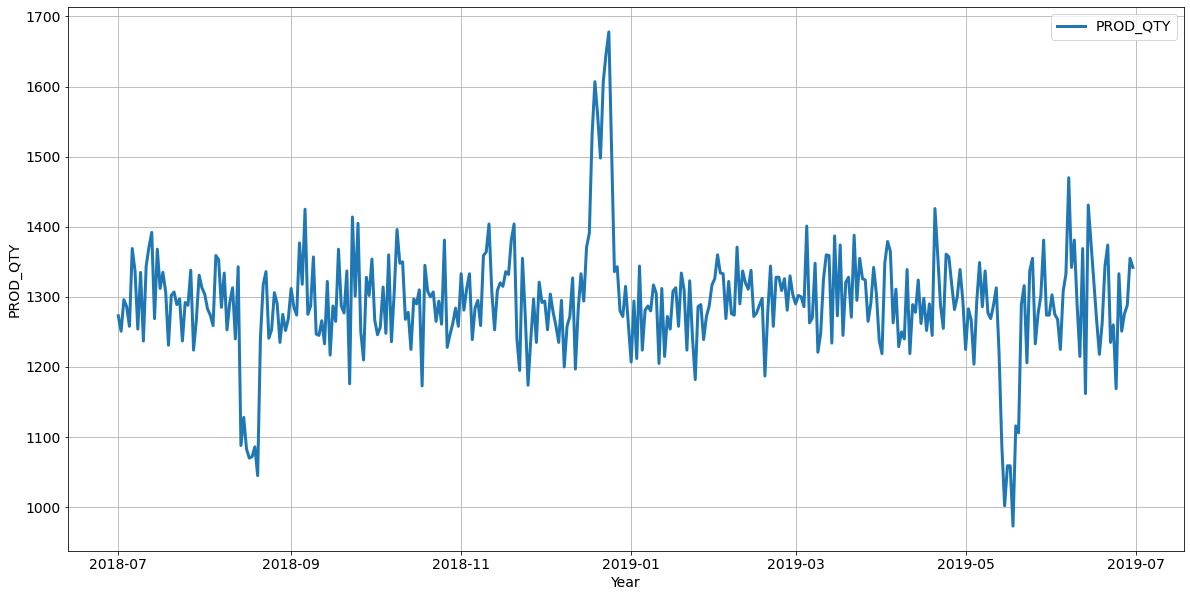

In [34]:
import matplotlib.pyplot as plt

sum_by_date = df_transaction_data.groupby(['DATE'])[['PROD_QTY', 'TOT_SALES']].sum()
sum_by_date.reset_index(inplace=True)


plt.figure(figsize=(20,10))
plt.plot(sum_by_date.DATE, sum_by_date.PROD_QTY, label='PROD_QTY',linewidth=3)
plt.grid(True)
plt.legend(fontsize=14)
plt.ylabel('PROD_QTY', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

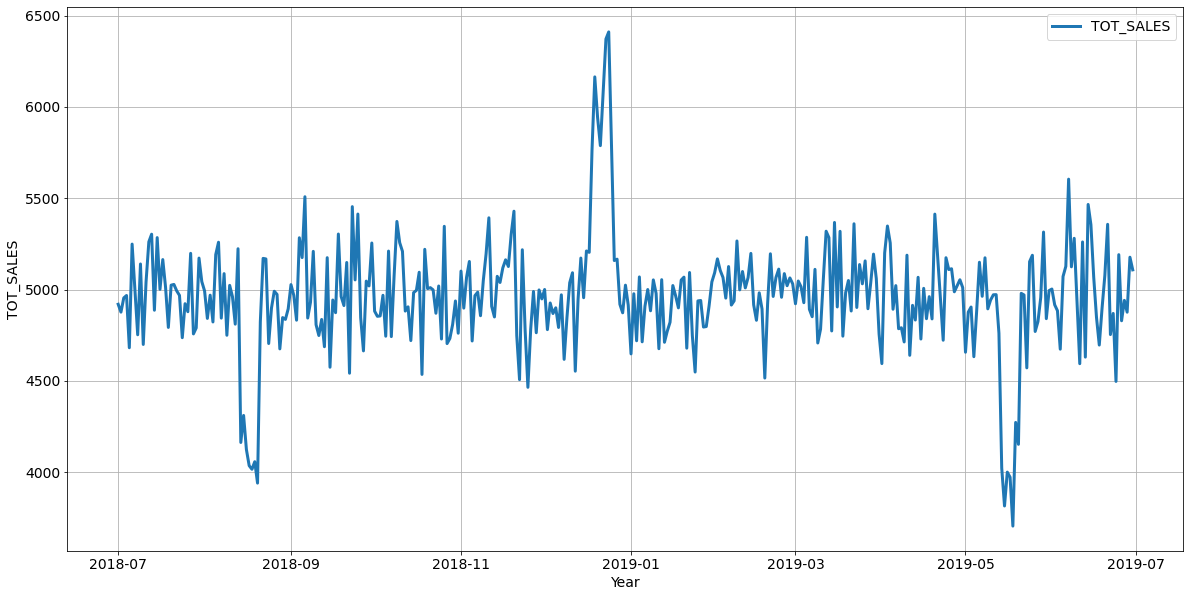

In [35]:
plt.figure(figsize=(20,10))
plt.plot(sum_by_date.DATE, sum_by_date.TOT_SALES, label='TOT_SALES',linewidth=3)
plt.grid(True)
plt.legend(fontsize=14)
plt.ylabel('TOT_SALES', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Both graphs seem to follow the same tendency, and we can clearly see 3 points of interest, let's look more into them.

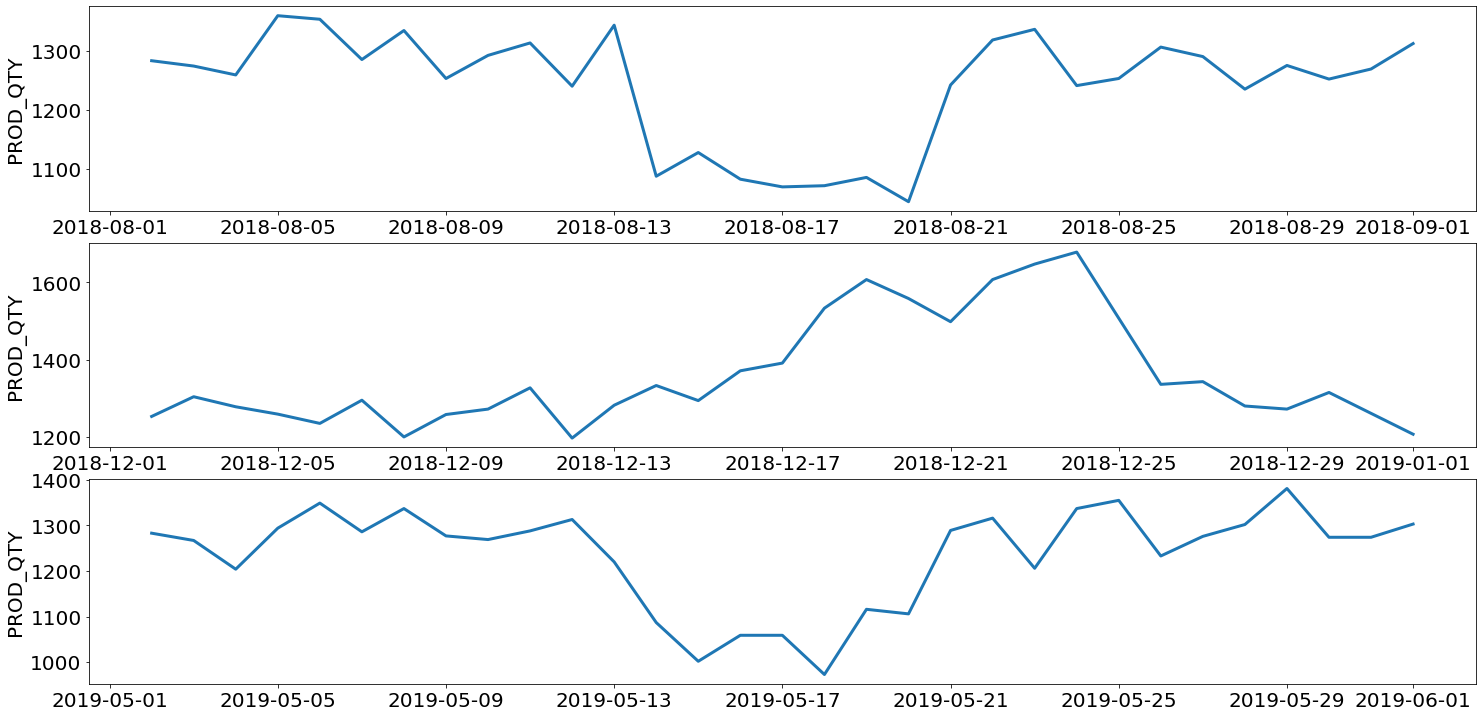

In [36]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10))  
fig.tight_layout()

date_ranges = [{'start':'2018-08-01','end':'2018-09-01'},
               {'start':'2018-12-01','end':'2019-01-01'},
               {'start':'2019-05-01','end':'2019-06-01'}]

axs = axs.ravel()

r = 0

for date_range in date_ranges:
    mask = (sum_by_date.DATE > date_range['start']) & (sum_by_date.DATE <= date_range['end'])
    axs[r].plot(sum_by_date.loc[mask].DATE, sum_by_date.loc[mask].PROD_QTY, label='TOT_SALES',linewidth=3)
    #axs[c,r].set_title(feature)
    
    axs[r].set_ylabel('PROD_QTY', fontdict={'fontsize': 20})
    axs[r].tick_params(axis='both', which='major', labelsize=20)
    
    r += 1


plt.show()

The spike ocurrs on the leading days to christmas. I can't see a particular reason for the plumet in sales numbers in the other graphs.

So far we have discoverd:

- There is one inconsistence, looks like a duplicated entry as even the 'TXN_ID' is repeated and it shouldn't.
- The transactions range from 2018-07-01 to 2019-06-30 with a missing date.
- The date with most sales was 2018-12-24 with 939 transactions, which is the day before christmas.
- There are 29 different brands and 113 different product names.
- The brand with the most transactions asociated with it is 'Kettle'.
- Package sizes ranges from 70g to 380g.
- Customers on avarage take 2 products per transaction.

### Purchase Behaviour Data

Now let's work on the other dataset before joining both. We'll be going over the similar points as before: describe the columns, check for duplicates and outliers.

In [37]:
df_purchase_behaviour

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
...,...,...,...
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget


In [38]:
# Check for nulls
df_purchase_behaviour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [39]:
# Duplicates?
df_purchase_behaviour[df_purchase_behaviour.duplicated(keep=False)]

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER


In [40]:
df_purchase_behaviour[['LIFESTAGE','PREMIUM_CUSTOMER']].describe()

,LIFESTAGE,PREMIUM_CUSTOMER
count,72637,72637
unique,7,3
top,RETIREES,Mainstream
freq,14805,29245


In [41]:
df_purchase_behaviour['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

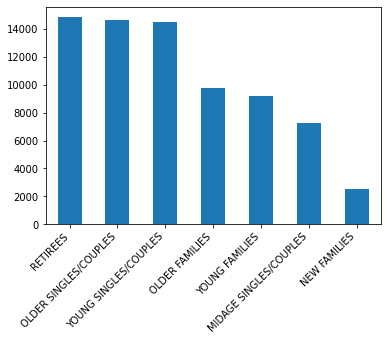

In [42]:
fig, ax = plt.subplots()
df_purchase_behaviour['LIFESTAGE'].value_counts().plot(ax=ax, kind='bar')
plt.xticks(rotation=45, ha='right')
plt.show()

In [43]:
df_purchase_behaviour['PREMIUM_CUSTOMER'].unique()

array(['Premium', 'Mainstream', 'Budget'], dtype=object)

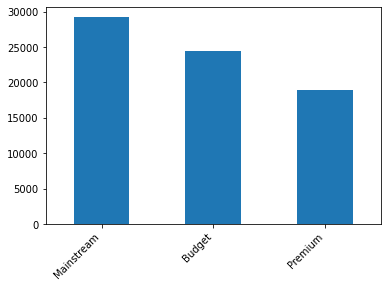

In [44]:
fig, ax = plt.subplots()
df_purchase_behaviour['PREMIUM_CUSTOMER'].value_counts().plot(ax=ax, kind='bar')
plt.xticks(rotation=45, ha='right')
plt.show()

A few things we learned with this dataset:
- There are no nulls or duplicates
- Most of our client fall under the Mainstream category in 'PREMIUM_CUSTOMER' 
- Looking at the life stage of our clients, most of them are Retirees and New Families are the minority group. 

---

## Merge data

Now let's join both datasets so we can make a better analysis. Both datasets have the 'LYLTY_CARD_NBR' column, we have to do a left join on that.

In [45]:
joined_df = pd.merge(df_transaction_data,df_purchase_behaviour,on='LYLTY_CARD_NBR',how='left')
joined_df

,index,OLD_DATE,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,OLD_PROD_NAME,PROD_NAME,BRND_NAME,PCK_SIZE,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,0,43390,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,Chip Compny SeaSalt,Natural,175,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,1,43599,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,Nacho Cheese,CCs,175,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,2,43605,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,Crinkle Cut Chips Chicken,Smiths,170,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,3,43329,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,Chip Thinly S/Cream&Onion,Smiths,175,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,4,43330,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,Tortilla ChpsHny&Jlpno Chili,Kettle,150,3,13.8,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246734,246736,43533,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,Sweet Chilli And Sour Cream,Kettle,175,2,10.8,YOUNG SINGLES/COUPLES,Premium
246735,246737,43325,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,Splash Of Lime,Tostitos,175,1,4.4,YOUNG SINGLES/COUPLES,Premium
246736,246738,43410,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,Mexicana,Doritos,170,2,8.8,YOUNG SINGLES/COUPLES,Premium
246737,246739,43461,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,Corn Chip Mexican Jalapeno,Doritos,150,2,7.8,YOUNG SINGLES/COUPLES,Premium


Now that we have the joined data, let's make sure that there are no transactions without customer data, or if there is any customer with no transactions that we might have left out.

In [46]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246739 entries, 0 to 246738
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   index             246739 non-null  int64         
 1   OLD_DATE          246739 non-null  int64         
 2   DATE              246739 non-null  datetime64[ns]
 3   STORE_NBR         246739 non-null  int64         
 4   LYLTY_CARD_NBR    246739 non-null  int64         
 5   TXN_ID            246739 non-null  int64         
 6   PROD_NBR          246739 non-null  int64         
 7   OLD_PROD_NAME     246739 non-null  object        
 8   PROD_NAME         246739 non-null  object        
 9   BRND_NAME         246739 non-null  object        
 10  PCK_SIZE          246739 non-null  int64         
 11  PROD_QTY          246739 non-null  int64         
 12  TOT_SALES         246739 non-null  float64       
 13  LIFESTAGE         246739 non-null  object        
 14  PREM

In [47]:
df_purchase_behaviour[~df_purchase_behaviour.LYLTY_CARD_NBR.isin(joined_df.LYLTY_CARD_NBR.unique())]

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
21,1028,YOUNG SINGLES/COUPLES,Budget
78,1117,OLDER SINGLES/COUPLES,Mainstream
90,1137,MIDAGE SINGLES/COUPLES,Premium
95,1143,OLDER FAMILIES,Budget
100,1152,RETIREES,Budget
...,...,...,...
72437,272164,YOUNG FAMILIES,Mainstream
72515,272276,YOUNG FAMILIES,Budget
72530,272295,RETIREES,Mainstream
72547,272321,OLDER SINGLES/COUPLES,Premium


All transactions have customer behaviour data, but we don't have transactions for every customer. This might be due to the fact that we have data in the range of a year, and those customer might not have made any purchase in that time.

Let's save the joined dataset in a separate csv file for later use.

In [48]:
joined_df.to_csv('./data/QVI_transaction_and_customer_data.csv', index=False)

Now that data exploration is complete, we can move over to the analysis part.

## Data analysis on customer segments 

We'll start of by defining some metrics of interest to the client that we will try to come up with an answer:
- How many customers are in each segment? What segment of clients represent most of our sales?
- Chip brands preference and the favourite per segment.
- Who spends the most on chips (total sales)?
- How many chips are bought per customer by segment?
- What's the average chip price by customer segment?
- The customer's total spend over the period and total spend for each transaction to understand what proportion of their grocery spend is on chips 
- Proportion of customers in each customer segment overall to compare against the mix of customers who purchase chips

Let's start with sales by customers segments

In [49]:
prod_sales_sum = joined_df[['LIFESTAGE','PREMIUM_CUSTOMER','LYLTY_CARD_NBR']].groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).count().sort_values(by='LYLTY_CARD_NBR', ascending=False)
prod_sales_sum = prod_sales_sum.rename(columns={'LYLTY_CARD_NBR': 'N_CUSTOMERS'})
total_sales = prod_sales_sum.N_CUSTOMERS.sum()
prod_sales_sum['PROPORTION'] = prod_sales_sum.N_CUSTOMERS / total_sales * 100
prod_sales_sum

N_CUSTOMERS  PROPORTION
LIFESTAGE              PREMIUM_CUSTOMER                         
OLDER FAMILIES         Budget                  21514    8.719335
RETIREES               Mainstream              19970    8.093573
YOUNG SINGLES/COUPLES  Mainstream              19544    7.920920
YOUNG FAMILIES         Budget                  17763    7.199105
OLDER SINGLES/COUPLES  Budget                  17172    6.959581
                       Mainstream              17061    6.914594
                       Premium                 16559    6.711140
RETIREES               Budget                  14225    5.765201
OLDER FAMILIES         Mainstream              13241    5.366399
RETIREES               Premium                 12236    4.959086
YOUNG FAMILIES         Mainstream              11947    4.841959
MIDAGE SINGLES/COUPLES Mainstream              11095    4.496654
YOUNG FAMILIES         Premium                 10784    4.370610
OLDER FAMILIES         Premium                 10403    4.216196
YOUNG SINGLES/COUPLES  Budget                   8573    3.474522
MIDAGE SINGLES/COUPLES Premium                  7612    3.085041
YOUNG SINGLES/COUPLES  Premium                  5852    2.371737
MIDAGE SINGLES/COUPLES Budget                   4691    1.901199
NEW FAMILIES           Budget                   2824    1.144529
                       Mainstream               2185    0.885551
                       Premium                  1488    0.603066

<AxesSubplot:xlabel='LIFESTAGE,PREMIUM_CUSTOMER'>

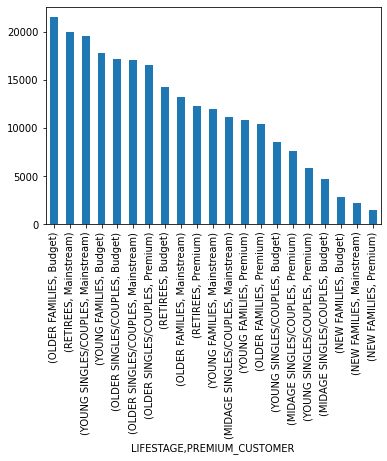

In [50]:
prod_sales_sum['N_CUSTOMERS'].plot.bar()

In [51]:
prod_sales_sum = joined_df[['LIFESTAGE','PREMIUM_CUSTOMER','TOT_SALES']].groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).sum().sort_values(by='TOT_SALES', ascending=False)
total_sales = prod_sales_sum.TOT_SALES.sum()
prod_sales_sum['PROPORTION_SALES'] = prod_sales_sum.TOT_SALES / total_sales * 100
prod_sales_sum

TOT_SALES  PROPORTION_SALES
LIFESTAGE              PREMIUM_CUSTOMER                             
OLDER FAMILIES         Budget            156863.75          8.689686
YOUNG SINGLES/COUPLES  Mainstream        147582.20          8.175521
RETIREES               Mainstream        145168.95          8.041836
YOUNG FAMILIES         Budget            129717.95          7.185906
OLDER SINGLES/COUPLES  Budget            127833.60          7.081520
                       Mainstream        124648.50          6.905077
                       Premium           123531.55          6.843202
RETIREES               Budget            105916.30          5.867381
OLDER FAMILIES         Mainstream         96413.55          5.340963
RETIREES               Premium            91296.65          5.057505
YOUNG FAMILIES         Mainstream         86338.25          4.782828
MIDAGE SINGLES/COUPLES Mainstream         84734.25          4.693972
YOUNG FAMILIES         Premium            78571.70          4.352589
OLDER FAMILIES         Premium            75242.60          4.168169
YOUNG SINGLES/COUPLES  Budget             57122.10          3.164358
MIDAGE SINGLES/COUPLES Premium            54443.85          3.015993
YOUNG SINGLES/COUPLES  Premium            39052.30          2.163357
MIDAGE SINGLES/COUPLES Budget             33345.70          1.847231
NEW FAMILIES           Budget             20607.45          1.141578
                       Mainstream         15979.70          0.885218
                       Premium            10760.80          0.596110

<AxesSubplot:xlabel='LIFESTAGE,PREMIUM_CUSTOMER'>

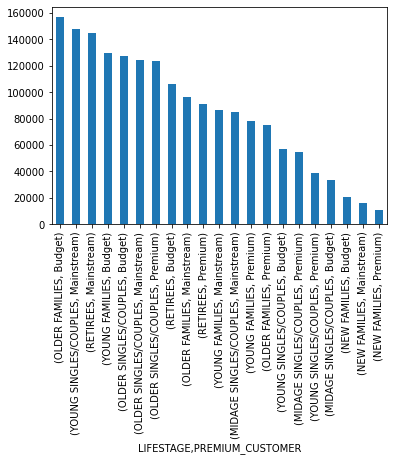

In [52]:
prod_sales_sum['TOT_SALES'].plot.bar()

With this we now know that **our top segment are OLDER FAMILIES/Budget, RETIREES/Mainstream and YOUNG SINGLES/COUPLES/Mainstream**, this contributes to there being more sales to these customer segments.

In [53]:
joined_df[['LIFESTAGE','PREMIUM_CUSTOMER','BRND_NAME']].groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).describe()

BRND_NAME                     
                                            count unique     top  freq
LIFESTAGE              PREMIUM_CUSTOMER                               
MIDAGE SINGLES/COUPLES Budget                4691     26  Kettle   713
                       Mainstream           11095     26  Kettle  2136
                       Premium               7612     26  Kettle  1206
NEW FAMILIES           Budget                2824     26  Kettle   510
                       Mainstream            2185     26  Kettle   414
                       Premium               1488     26  Kettle   247
OLDER FAMILIES         Budget               21514     26  Kettle  3320
                       Mainstream           13241     26  Kettle  2019
                       Premium              10403     26  Kettle  1512
OLDER SINGLES/COUPLES  Budget               17172     26  Kettle  3065
                       Mainstream           17061     26  Kettle  2835
                       Premium              16559     26  Kettle  2947
RETIREES               Budget               14225     26  Kettle  2592
                       Mainstream           19970     26  Kettle  3386
                       Premium              12236     26  Kettle  2216
YOUNG FAMILIES         Budget               17763     26  Kettle  2743
                       Mainstream           11947     26  Kettle  1789
                       Premium              10784     26  Kettle  1745
YOUNG SINGLES/COUPLES  Budget                8573     26  Kettle  1211
                       Mainstream           19544     26  Kettle  3844
                       Premium               5852     26  Kettle   838

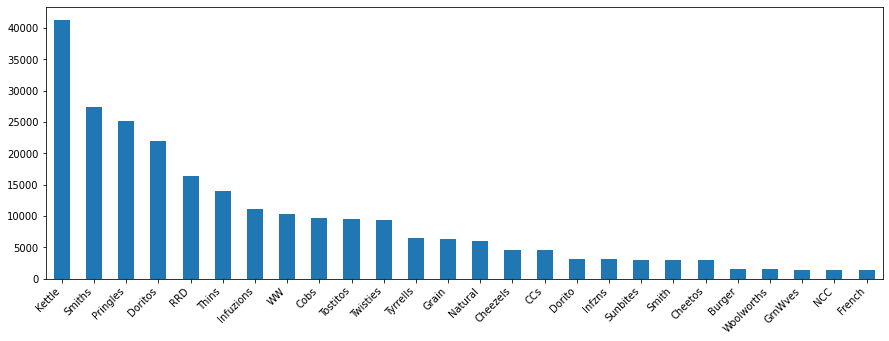

In [54]:
fig, ax = plt.subplots(figsize=(15,5))
joined_df['BRND_NAME'].value_counts().plot(ax=ax, kind='bar')
plt.xticks(rotation=45, ha='right')
plt.show()

In [55]:
joined_df[['PREMIUM_CUSTOMER','BRND_NAME']].groupby(['PREMIUM_CUSTOMER']).describe()

BRND_NAME                      
                     count unique     top   freq
PREMIUM_CUSTOMER                                
Budget               86762     26  Kettle  14154
Mainstream           95043     26  Kettle  16423
Premium              64934     26  Kettle  10711

With the table and graph we see that **Kettle is the top brand preferred by most groups and is top saled brand overall**, even accross those with budget and premium purchase behaviour.

In [56]:
prod_sales_sum = joined_df[['LYLTY_CARD_NBR','TOT_SALES']].groupby('LYLTY_CARD_NBR').sum().sort_values(by='TOT_SALES', ascending=False).head(10)
pd.merge(prod_sales_sum,df_purchase_behaviour,on='LYLTY_CARD_NBR',how='left')

,LYLTY_CARD_NBR,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,230078,138.6,OLDER FAMILIES,Budget
1,58361,124.8,YOUNG FAMILIES,Budget
2,63197,122.6,OLDER FAMILIES,Budget
3,162039,121.6,OLDER FAMILIES,Mainstream
4,179228,120.8,YOUNG FAMILIES,Budget
5,199157,118.8,YOUNG FAMILIES,Premium
6,3153,116.4,MIDAGE SINGLES/COUPLES,Premium
7,95048,115.1,YOUNG SINGLES/COUPLES,Mainstream
8,5168,114.8,OLDER FAMILIES,Mainstream
9,23192,114.7,OLDER FAMILIES,Budget


Here there is a top 10 list of our customer based on their spendings. Interestingly, **our top costumer doesn't have a premium but a butget purchasing behaviour**

In [57]:
joined_df[['LIFESTAGE','PREMIUM_CUSTOMER','PROD_QTY']].groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).mean().sort_values(by='PROD_QTY', ascending=False)

PROD_QTY
LIFESTAGE              PREMIUM_CUSTOMER          
OLDER FAMILIES         Mainstream        1.948795
                       Premium           1.945496
                       Budget            1.945384
YOUNG FAMILIES         Mainstream        1.941408
                       Budget            1.941226
                       Premium           1.938149
OLDER SINGLES/COUPLES  Budget            1.914920
                       Premium           1.913944
MIDAGE SINGLES/COUPLES Mainstream        1.911942
OLDER SINGLES/COUPLES  Mainstream        1.911201
RETIREES               Premium           1.901438
MIDAGE SINGLES/COUPLES Budget            1.893626
RETIREES               Budget            1.893286
MIDAGE SINGLES/COUPLES Premium           1.891750
RETIREES               Mainstream        1.886680
NEW FAMILIES           Premium           1.860887
                       Mainstream        1.858124
                       Budget            1.855878
YOUNG SINGLES/COUPLES  Mainstream        1.853510
                       Budget            1.808002
                       Premium           1.807075

**Older and young families in general buy more chips per customer.** This helps they beign on top of our sales charts from before.

In [58]:
joined_df['AVG_PRICE'] = joined_df.TOT_SALES / joined_df.PROD_QTY
joined_df[['LIFESTAGE','PREMIUM_CUSTOMER','AVG_PRICE']].groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).mean().sort_values(by='AVG_PRICE', ascending=False)

AVG_PRICE
LIFESTAGE              PREMIUM_CUSTOMER           
YOUNG SINGLES/COUPLES  Mainstream         4.065642
MIDAGE SINGLES/COUPLES Mainstream         3.994241
RETIREES               Budget             3.924404
                       Premium            3.920942
NEW FAMILIES           Budget             3.917688
                       Mainstream         3.916133
OLDER SINGLES/COUPLES  Premium            3.893236
                       Budget             3.882096
NEW FAMILIES           Premium            3.872110
RETIREES               Mainstream         3.844294
OLDER SINGLES/COUPLES  Mainstream         3.814665
MIDAGE SINGLES/COUPLES Premium            3.770698
YOUNG FAMILIES         Premium            3.762150
                       Budget             3.760737
OLDER FAMILIES         Budget             3.745340
MIDAGE SINGLES/COUPLES Budget             3.743328
OLDER FAMILIES         Mainstream         3.737077
YOUNG FAMILIES         Mainstream         3.724533
OLDER FAMILIES         Premium            3.717000
YOUNG SINGLES/COUPLES  Premium            3.665414
                       Budget             3.657366

In the table above we can se the average chip price by customer segment. Our Young and Midage Single/Couples Mainstream tend to pay more for chips than their budget and premium counterparts.

As the difference in average price per unit isn't large, we can check if this difference is statistically different.

In [59]:
from scipy.stats import ttest_ind

filter_df = joined_df[(joined_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (joined_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES')]
mainstream_group = filter_df[filter_df.PREMIUM_CUSTOMER == 'Mainstream']
budget_premium_group = filter_df[~(filter_df.PREMIUM_CUSTOMER == 'Mainstream')]

t2, p2 = ttest_ind(mainstream_group.AVG_PRICE, budget_premium_group.AVG_PRICE)

print('P-Value = {}'.format(p2))

P-Value = 2.235645611549355e-309


The t-test results in a p-value close to zero, i.e. the unit price for mainstream, young and mid-age singles and couples ARE significantly higher than that of budget or premium, young and midage singles and couples.

With all that we have seen so far we should focus on reteining those customers that tend to pay more per chips, **that beeing Young and Midage Single/Couples Mainstream**. Also having in mind that their preferd brand is **Kettle**. 

In [60]:
filter_df.PCK_SIZE = filter_df.PCK_SIZE.astype('str')
filter_df.groupby('LIFESTAGE')['PCK_SIZE'].value_counts()

LIFESTAGE               PCK_SIZE
MIDAGE SINGLES/COUPLES  175         6334
                        150         3755
                        134         2389
                        110         2223
                        170         1835
                        165         1448
                        330         1220
                        270          649
                        380          628
                        210          613
                        200          388
                        135          309
                        160          290
                        250          282
                        190          266
                        90           249
                        220          152
                        70           141
                        180          119
                        125          108
YOUNG SINGLES/COUPLES   175         8953
                        150         5403
                        134         3684
                        

We should also have in mind that our segment of interest prefers medium size packs of chips, **175g is preferred for both groups**.